# The notebook contains
### Code for _Bulyan_ aggregation algorithm
### Evaluation of our SOTA AGR-tailored attack on Bulyan

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Hizan\AppData\Local\Temp\ipykernel_1400\912229180.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math, json
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp

sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from femnist_normal_train import *
from femnist_util import *
from adam import Adam
from sgd import SGD
import torchvision.transforms as transforms
import torchvision.datasets as datasets

## Get the FEMNIST dataset; we use [LEAF framework](https://leaf.cmu.edu/)

In [3]:
user_tr_data = []
user_tr_labels = []

for i in range(34):
    f = '/mnt/nfs/work1/amir/vshejwalkar/femnist/data/train/all_data_%d_niid_0_keep_0_train_9.json'%i
    with open(f, 'r') as myfile:
        data=myfile.read()
    obj = json.loads(data)
    
    for user in obj['users']:
        user_tr_data.append(obj['user_data'][user]['x'])
        user_tr_labels.append(obj['user_data'][user]['y'])

user_te_data = []
user_te_labels = []

for i in range(34):
    f = '/mnt/nfs/work1/amir/vshejwalkar/femnist/data/test/all_data_%d_niid_0_keep_0_test_9.json'%i
    with open(f, 'r') as myfile:
        data=myfile.read()
    obj = json.loads(data)
    
    for user in obj['users']:
        user_te_data.append(obj['user_data'][user]['x'])
        user_te_labels.append(obj['user_data'][user]['y'])

In [4]:
user_tr_data_tensors=[]
user_tr_label_tensors=[]

for i in range(len(user_tr_data)):
    
    user_tr_data_tensor=torch.from_numpy(np.array(user_tr_data[i])).type(torch.FloatTensor)
    user_tr_label_tensor=torch.from_numpy(np.array(user_tr_labels[i])).type(torch.LongTensor)

    user_tr_data_tensors.append(user_tr_data_tensor)
    user_tr_label_tensors.append(user_tr_label_tensor)
    
    # print('user %d tr len %d'%(i,len(user_tr_data_tensor)))

In [5]:
te_data = np.concatenate(user_te_data, 0)
te_labels = np.concatenate(user_te_labels)
te_len = len(te_labels)

te_data_tensor = torch.from_numpy(te_data[:(te_len//2)]).type(torch.FloatTensor)
te_label_tensor = torch.from_numpy(te_labels[:(te_len//2)]).type(torch.LongTensor)

val_data_tensor = torch.from_numpy(te_data[(te_len//2):]).type(torch.FloatTensor)
val_label_tensor = torch.from_numpy(te_labels[(te_len//2):]).type(torch.LongTensor)

## Code for Multi-krum aggregation algorithm

In [6]:
def multi_krum(all_updates, n_attackers, multi_k=False):
    candidates = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(remaining_updates) > 2 * n_attackers + 2:
        distances = []
        for update in remaining_updates:
            distance = torch.norm((remaining_updates - update), dim=1) ** 2
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]
        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        candidates = remaining_updates[indices[0]][None, :] if not len(candidates) else torch.cat((candidates, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)
        if not multi_k:
            break
    # print(len(remaining_updates))
    aggregate = torch.mean(candidates, dim=0)
    return aggregate, np.array(candidate_indices)


## Code for Bulyan aggregation algorithm

In [7]:
def bulyan(all_updates, n_attackers):
    nusers = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (nusers - 2 * n_attackers):
        distances = []
        for update in remaining_updates:
            distance = torch.norm((remaining_updates - update), dim=1) ** 2
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]

        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## Code for Fang attack on Bulyan
### Fang attacks on MKrum and Bulyan are the same

In [8]:
def our_attack_mkrum(all_updates, model_re, n_attackers,dev_type='unit_vec'):

    if dev_type == 'unit_vec':
        deviation = model_re / torch.norm(model_re)  # unit vector, dir opp to good dir
    elif dev_type == 'sign':
        deviation = torch.sign(model_re)
    elif dev_type == 'std':
        deviation = torch.std(all_updates, 0)
        
    lamda = torch.Tensor([20.0]).cuda() #compute_lambda_our(all_updates, model_re, n_attackers)
    # print(lamda)
    threshold_diff = 1e-5
    lamda_fail = lamda
    lamda_succ = 0

    while torch.abs(lamda_succ - lamda) > threshold_diff:
        mal_update = (model_re - lamda * deviation)
        mal_updates = torch.stack([mal_update] * n_attackers)
        mal_updates = torch.cat((mal_updates, all_updates), 0)

        agg_grads, krum_candidate = multi_krum(mal_updates, n_attackers, multi_k=True)

        if np.sum(krum_candidate < n_attackers) == n_attackers:
            # print('successful lamda is ', lamda)
            lamda_succ = lamda
            lamda = lamda + lamda_fail / 2
        else:
            lamda = lamda - lamda_fail / 2

        lamda_fail = lamda_fail / 2

    mal_update = (model_re - lamda_succ * deviation)

    return mal_update

In [9]:
resume=0
nepochs = 500
gamma=.1
fed_lr=0.001

criterion = nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()
batch_size = 100
schedule = [2000]

aggregation = 'bulyan'
at_type = 'our-agr'
chkpt = './' + aggregation
epoch_num = 0

at_fractions = [0]

for at_fraction in at_fractions:

    fed_model = mnist_conv().cuda()
    fed_model.apply(weights_init)
    optimizer_fed = Adam(fed_model.parameters(), lr=fed_lr)

    print('==> Initializing global model')
    epoch_num = 0
    best_global_acc=0
    best_global_te_acc=0

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    while epoch_num <= nepochs:
        user_grads = []

        round_users = np.random.choice(3400, 60)
        n_attacker = max(2, np.sum(round_users < (34*at_fraction)))
        # n_attacker = 0
        if n_attacker > 14:
            print ('n_attacker actual %d adjusted 14' % n_attacker)
            n_attacker = 14

        print('n_attacker is ', n_attacker)
        attacker_count = 0
        for i in round_users:
            if i < (34*at_fraction) and attacker_count < n_attacker:
                attacker_count += 1
                continue

            inputs = user_tr_data_tensors[i]
            targets = user_tr_label_tensors[i]

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            optimizer_fed.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None,:] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]),0)    

        malicious_grads = user_grads

        if n_attacker > 0:
            if at_type == 'fang':
                agg_grads = torch.mean(malicious_grads, 0)
                deviation = torch.sign(agg_grads)
                mal_update = get_malicious_updates_fang(malicious_grads, agg_grads, deviation, n_attacker)

            elif at_type == 'our-agr':
                agg_grads = torch.mean(malicious_grads, 0)
                mal_update = our_attack_mkrum(malicious_grads, agg_grads, n_attacker, dev_type='sign')
            
            mal_updates = torch.stack([mal_update] * n_attacker)
            malicious_grads = torch.cat((mal_updates, user_grads), 0)    
        
        if epoch_num == 0: print('malicious grads shape ', malicious_grads.shape)

        if aggregation == 'mean':
            agg_grads=torch.mean(malicious_grads,dim=0)
            
        elif aggregation=='krum' or aggregation=='mkrum':
            multi_k = True if aggregation == 'mkrum' else False
            if epoch_num == 0: print('multi krum is ', multi_k)
            agg_grads, krum_candidate = multi_krum(malicious_grads, n_attacker, multi_k=multi_k)

        elif aggregation == 'bulyan':
            agg_grads, krum_candidate = bulyan(malicious_grads, n_attacker)
            
        start_idx=0

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        print('epoch: %d, %s: at %s n_at %d n_mal_sel %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, np.sum(krum_candidate < n_attacker), epoch_num, val_loss, val_acc, best_global_acc))

        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)

        epoch_num+=1

==> Initializing global model
n_attacker is  2
malicious grads shape  torch.Size([62, 848382])


c:\Users\Hizan\Desktop\CPEN497-FL\CPEN497-499\adam.py:76: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1630.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


epoch: 0, bulyan: at our-agr n_at 2 n_mal_sel 2 e 0 | val loss 3.8441 val acc 5.9904 best val_acc 5.990440
n_attacker is  2


C:\Users\Hizan\AppData\Local\Temp\ipykernel_1400\2515889268.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 2 n_mal_sel 2 e 1 | val loss 3.6647 val acc 5.9904 best val_acc 5.990440
n_attacker is  2
epoch: 2, bulyan: at our-agr n_at 2 n_mal_sel 2 e 2 | val loss 3.6675 val acc 6.7460 best val_acc 6.745991
n_attacker is  2
epoch: 3, bulyan: at our-agr n_at 2 n_mal_sel 2 e 3 | val loss 3.6352 val acc 5.9493 best val_acc 6.745991
n_attacker is  2
epoch: 4, bulyan: at our-agr n_at 2 n_mal_sel 2 e 4 | val loss 3.5925 val acc 5.9519 best val_acc 6.745991
n_attacker is  2
epoch: 5, bulyan: at our-agr n_at 2 n_mal_sel 2 e 5 | val loss 3.5785 val acc 9.7990 best val_acc 9.799034
n_attacker is  2
epoch: 6, bulyan: at our-agr n_at 2 n_mal_sel 2 e 6 | val loss 3.5926 val acc 10.4621 best val_acc 10.462068
n_attacker is  2
epoch: 7, bulyan: at our-agr n_at 2 n_mal_sel 2 e 7 | val loss 3.5998 val acc 7.6480 best val_acc 10.462068
n_attacker is  2
epoch: 8, bulyan: at our-agr n_at 2 n_mal_sel 2 e 8 | val loss 3.5903 val acc 14.2989 best val_acc 14.298931
n_attacker is  2
epo

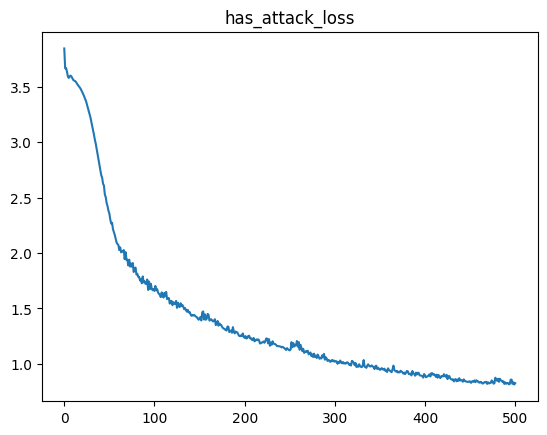

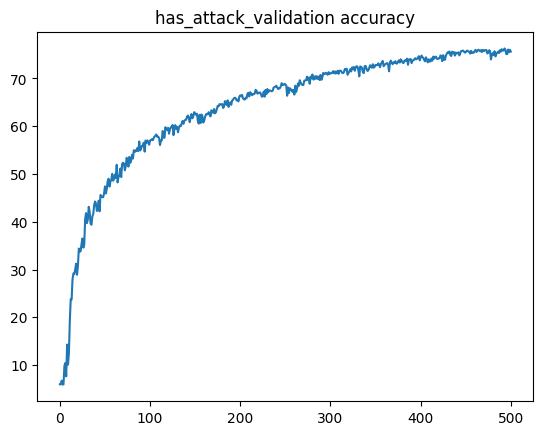

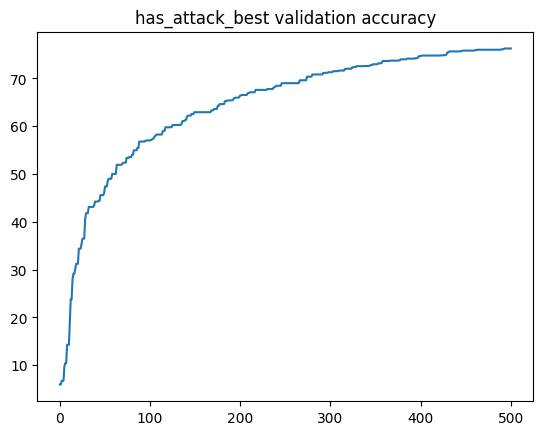

In [11]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("has_attack_"+col)
    plt.savefig('./no_attack_FEMNIST_' + col + '.png')
    plt.show()